In [1]:
#Astr400B Hw 5
#James Taylor
#Worked with Trevor Smith, Michael Klein

In [2]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt
import matplotlib
from astropy.constants import G
from CenterOfMass import CenterOfMass 
from ReadFile import Read

In [3]:
# Create a class called MassProfile in order to mass profile of a given galaxy

In [9]:
class MassProfile:
    # Inputs 
    #    galaxy: the name of the specific galazxy for which data is collected from
    #    snap: snapshot number for the galaxy
    def __init__(self,galaxy,Snap):
        # add a string of the filename to the value '000'
        ilbl = '000' + str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        # Open the file and reads in the data
        self.time, self.total, self.data = Read(self.filename)
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.type = self.data['type']
        self.gname = galaxy
    # Create a function to compute the mass within a given radius from the COM position
    def MassEnclosed(self,ptype, r):
        # Inputs
        #    type: particle type
        #    radius: array of radii
        # Generate center of mass object
        COM = CenterOfMass(self.filename, ptype)
        
        # Get center of mass position
        delta = 0.1
        #COM_P = CenterOfMass.COM_P(delta)
        XCOM, YCOM, ZCOM = COM.COM_P(delta)
        # Update particle position 
        xNew = self.x - XCOM
        yNew = self.y - YCOM
        zNew = self.z - ZCOM
        # Select particles of only a given type (ptype)
        index = np.where(self.type == ptype)
        xNew2 = xNew[index]
        yNew2 = yNew[index]
        zNew2 = zNew[index]
        # Calculate the magnitude
        R = np.sqrt(xNew2**2 + yNew2**2 + zNew2**2)
        # Generate array of radii
        enclosed_mass = np.zeros(len(r))
        # Loop over array of radii to calculate the enclosed mass
        for i in range(len(r)):
            # Get indecies for particels within the given radius
            index_R = np.where(R < r[i])
            # Add the mass to the enclosed mass array 
            enclosed_mass[i] = np.sum(self.m[index_R])
        # Returns the mass enclosed within a given radius
        return enclosed_mass*1e10*u.Msun
   
    # Create a function in order to compute the total mass of the bulge+disk+halo for each radius
    def MassEnclosedTotal(self,r):
        # Inputs 
        #    Array of radii
        # M33 does not have a bulge, therefore the total mass will only be comprised of 
        # halo + disk
        DiskMass = self.MassEnclosed(2,r)
        DarkMass = self.MassEnclosed(1,r)
        # Since M33 does not have a bulge, the mass of a bulge will only be calculated for
        # M31 and the Milky Way
        if self.gname == M33:
            BulgeMass = np.zeros(len(r))
        else: 
            BulgeMass = self.MassEnclosed(3,r)
        # returns the total enclosed mass
        return DiskMass + DarkMass + BulgeMass
    # Create a function that computes the enclosed mass for a given radius using the Hernquist profile
    def HernquistMass(self,r,a,Mhalo):
        # Inputs 
        #    r: the array of radii (kpc)
        #    a: scale factor for Hernquist profile (kpc)
        #    Mhalo: dark matter mass within the halo (Msun)
        # Returns 
        #    enclosed mass calculated using Hernquist profile
        return Mhalo*r**2/(a+r)**2
    # Create a function to calculate the circular speeds of the particles within a given radius
    def CircularVelocity(self,ptype,r):
        # Inputs
        #    ptype: particle type, 1: Dark Matter Halo, 2: Disk, 3: Bulge 
        #    r: array of radii(kpc)
        # Convert G to kpc*km**2/s**2/Msun in order to get velocity in km/s
        #G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # Return the orbital velocity at a given radius
        return np.round(np.sqrt(G*self.MassEnclosed(ptype,r)/r),2)
    def TotalCircularVelocity(self,r):
        # Inputs
        #    ptype: particle type, 1: Dark Matter Halo, 2: Disk, 3: Bulge 
        #    r: array of radii(kpc)
        # Convert G to kpc*km**2/s**2/Msun in order to get velocity in km/s
        #G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # Return the total orbital velocity rounded to two decimal places
        return np.round(np.sqrt(G*self.MassEnclosedTotal(ptype,r)/r),2)
    # Create a function to calculate the circular velocity assuming a Hernquist Profile
    def HernquistVCir(self,r,a,Mhalo):
        # Inputs 
        #    r: the array of radii (kpc)
        #    a: scale factor for Hernquist profile (kpc)
        #    Mhalo: dark matter mass within the halo (Msun)
        # Convert G to kpc*km**2/s**2/Msun in order to get velocity in km/s
        #G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # Returns 
        #    Circular velocity for a Hernquist Mass Profile
        return np.round(np.sqrt(G*self.HernquistMass(r,a,Mhalo)/r),2)
    # Plot

In [10]:
# Create an array of radius, starting from 0.1kpc out to 30kpc with even steps
r = np.linspace(0.1,30)*u.kpc
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [6]:
# Milky Way Mass Profiles and Halo Mass Calculation 
MassP_MW = MassProfile('MW',0)
Halo_MW = MassP_MW.MassEnclosed(1,r)
Disk_MW = MassP_MW.MassEnclosed(2,r)
Bulge_MW = MassP_MW.MassEnclosed(3,r)
indecies = np.where(MassP_MW.type ==1)

Mhalo_MW = np.sum(MassP_MW.m[indecies])
Halo_MW_Hern = MassP_MW.HernquistMass(r,100*u.kpc, Mhalo_MW)
# M33 Mass Profile and Halo Mass Calculation
MassP_33 = MassProfile('M33',0)
Halo_33 = MassP_33.MassEnclosed(1,r)
Disk_33 = MassP_33.MassEnclosed(2,r)
indecies = np.where(MassP_33.type ==1)
Mhalo_33 = np.sum(MassP_33.m[indecies])
Halo_33_Hern = MassP_MW.HernquistMass(r,100*u.kpc, Mhalo_33)
# M31 Mass Profile and Halo Mass Calculation
MassP_31 = MassProfile('M31',0)
Halo_31 = MassP_31.MassEnclosed(1,r)
Disk_31 = MassP_31.MassEnclosed(2,r)
Bulge_31 = MassP_31.MassEnclosed(3,r)
indecies = np.where(MassP_31.type ==1)
Mhalo_31 = np.sum(MassP_31.m[indecies])
Halo_31_Hern = MassP_MW.HernquistMass(r,100*u.kpc, Mhalo_31)

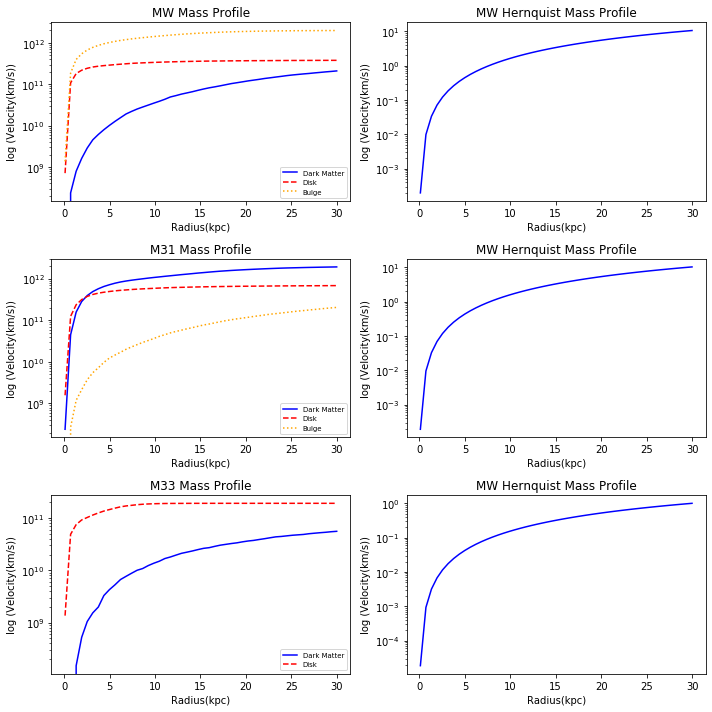

In [7]:
# Plot Results
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))
# Plot the mass distribution for the Milky Way

ax[0,0].semilogy(r, Halo_MW, linestyle='solid', color='blue', label = 'Dark Matter')
ax[0,0].semilogy(r,Bulge_MW, linestyle='dashed', color='red', label = 'Disk')
ax[0,0].semilogy(r,Disk_MW, linestyle='dotted', color='orange', label = 'Bulge')
ax[0,0].set_ylabel('log (Velocity(km/s))')
ax[0,0].set_xlabel('Radius(kpc)')
ax[0,0].set_title('MW Mass Profile')
legend = ax[0,0].legend(loc='lower right',fontsize='x-small')

# Plot the Velocity distribution for M31
ax[1,0].semilogy(r, Disk_31, linestyle='solid', color='blue', label = 'Dark Matter')
ax[1,0].semilogy(r,Bulge_31, linestyle='dashed', color='red', label = 'Disk')
ax[1,0].semilogy(r,Halo_31, linestyle='dotted', color='orange', label = 'Bulge')
ax[1,0].set_ylabel('log (Velocity(km/s))')
ax[1,0].set_xlabel('Radius(kpc)')
ax[1,0].set_title('M31 Mass Profile')
legend = ax[1,0].legend(loc='lower right',fontsize='x-small')

# Plot the Velocity distribution for M33
ax[2,0].semilogy(r, Halo_33, linestyle='solid', color='blue', label = 'Dark Matter')
ax[2,0].semilogy(r,Disk_33, linestyle='dashed', color='red', label = 'Disk')
legend = ax[2,0].legend(loc='lower right',fontsize='x-small')
ax[2,0].set_ylabel('log (Velocity(km/s))')
ax[2,0].set_xlabel('Radius(kpc)')
ax[2,0].set_title('M33 Mass Profile')

# Plot Hernquist Velocity Distribution for MW
ax[0,1].semilogy(r, Halo_MW_Hern, linestyle='solid', color='blue')
ax[0,1].set_ylabel('log (Velocity(km/s))')
ax[0,1].set_xlabel('Radius(kpc)')
ax[0,1].set_title('MW Hernquist Mass Profile')

# Plot Hernquist Velocity Distribution for M31
ax[1,1].semilogy(r, Halo_31_Hern, linestyle='solid', color='blue')
ax[1,1].set_ylabel('log (Velocity(km/s))')
ax[1,1].set_xlabel('Radius(kpc)')
ax[1,1].set_title('MW Hernquist Mass Profile')

# Plot Hernquist Velocity Distribution for M33
ax[2,1].semilogy(r, Halo_33_Hern, linestyle='solid', color='blue')
ax[2,1].set_ylabel('log (Velocity(km/s))')
ax[2,1].set_xlabel('Radius(kpc)')
ax[2,1].set_title('MW Hernquist Mass Profile')
plt.tight_layout()

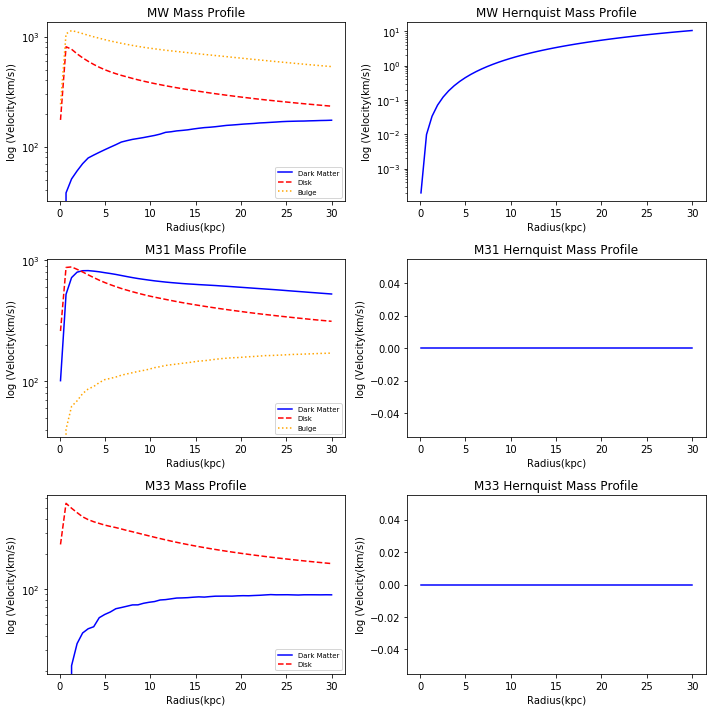

In [19]:
# Plot the Rotation Curve 
VelP_MW = MassProfile('MW',0)
Halo_MW_Vel = VelP_MW.CircularVelocity(1,r)
Disk_MW_Vel = VelP_MW.CircularVelocity(2,r)
Bulge_MW_Vel = VelP_MW.CircularVelocity(3,r)
Halo_MW_Hern_Vel = VelP_MW.HernquistVCir(r,100*u.kpc, Mhalo_MW)
VelP_M31 = MassProfile('M31',0)
Halo_M31_Vel = VelP_M31.CircularVelocity(1,r)
Disk_M31_Vel = VelP_M31.CircularVelocity(2,r)
Bulge_M31_Vel = VelP_M31.CircularVelocity(3,r)
Halo_31_Hern_Vel = VelP_M31.HernquistVCir(r,67*u.kpc, Mhalo_31)
VelP_M33 = MassProfile('M33',0)
Halo_M33_Vel = VelP_M33.CircularVelocity(1,r)
Disk_M33_Vel = VelP_M33.CircularVelocity(2,r)
Halo_33_Hern_Vel = VelP_M33.HernquistVCir(r,67*u.kpc, Mhalo_33)
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

# Plot the Velocity Distribution for the Milky Way
ax[0,0].semilogy(r, Halo_MW_Vel, linestyle='solid', color='blue', label = 'Dark Matter')
ax[0,0].semilogy(r,Bulge_MW_Vel, linestyle='dashed', color='red', label = 'Disk')
ax[0,0].semilogy(r,Disk_MW_Vel, linestyle='dotted', color='orange', label = 'Bulge')
ax[0,0].set_ylabel('log (Velocity(km/s))')
ax[0,0].set_xlabel('Radius(kpc)')
ax[0,0].set_title('MW Mass Profile')
legend = ax[0,0].legend(loc='lower right',fontsize='x-small')

# Plot the Velocity distribution for M31
ax[1,0].semilogy(r, Disk_M31_Vel, linestyle='solid', color='blue', label = 'Dark Matter')
ax[1,0].semilogy(r,Bulge_M31_Vel, linestyle='dashed', color='red', label = 'Disk')
ax[1,0].semilogy(r,Halo_M31_Vel, linestyle='dotted', color='orange', label = 'Bulge')
ax[1,0].set_ylabel('log (Velocity(km/s))')
ax[1,0].set_xlabel('Radius(kpc)')
ax[1,0].set_title('M31 Mass Profile')
legend = ax[1,0].legend(loc='lower right',fontsize='x-small')

# Plot the Velocity distribution for M33
ax[2,0].semilogy(r, Halo_M33_Vel, linestyle='solid', color='blue', label = 'Dark Matter')
ax[2,0].semilogy(r,Disk_M33_Vel, linestyle='dashed', color='red', label = 'Disk')
legend = ax[2,0].legend(loc='lower right',fontsize='x-small')
ax[2,0].set_ylabel('log (Velocity(km/s))')
ax[2,0].set_xlabel('Radius(kpc)')
ax[2,0].set_title('M33 Mass Profile')

# Plot Hernquist Velocity Distribution for MW
ax[0,1].semilogy(r, Halo_MW_Hern, linestyle='solid', color='blue')
ax[0,1].set_ylabel('log (Velocity(km/s))')
ax[0,1].set_xlabel('Radius(kpc)')
ax[0,1].set_title('MW Hernquist Mass Profile')

# Plot Hernquist Velocity Distribution for M31
ax[1,1].plot(r, Halo_31_Hern_Vel, linestyle='solid', color='blue')
ax[1,1].set_ylabel('log (Velocity(km/s))')
ax[1,1].set_xlabel('Radius(kpc)')
ax[1,1].set_title('M31 Hernquist Mass Profile')

# Plot Hernquist Velocity Distribution for M33
ax[2,1].plot(r, Halo_33_Hern_Vel, linestyle='solid', color='blue')
ax[2,1].set_ylabel('log (Velocity(km/s))')
ax[2,1].set_xlabel('Radius(kpc)')
ax[2,1].set_title('M33 Hernquist Mass Profile')
plt.tight_layout()